# Data

## Dataset

In [9]:
import os
import json
import torch
import random
from datetime import datetime
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utils import savgol, minmax_scaler, get_logger

label_names = ['AA_SN_X', 'AA_SN_Y', 'AA_SN_Z', 'GH_AA_X', 'GH_AA_Y', 'GH_AA_Z']

class Sensor2AngleDataset(Dataset):
    def __init__(self, dataDir, windowLength):
        self.dataDir = dataDir
        self.windowLength = windowLength
        self.data = self.load_data(dataDir, windowLength)   
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        sensorSample, angleSample = self.data[index]
        return sensorSample, angleSample
    
    def load_data(self, dataDir, windowLength, doStandardize=True, doFilter=True):
        sensorPath = Path(dataDir) / "sensor.npy"
        anglePath = Path(dataDir) / "angle.npy"
        with open(sensorPath, 'rb') as f:
            sensorAll = np.load(f)
        with open(anglePath, 'rb') as f:
            angleAll = np.load(f)
        assert sensorAll.shape[0] == angleAll.shape[0]
        if doStandardize:
            sensorAll = self.standardize_sensor(sensorAll)
        if doFilter:
            sensorAll, angleAll = self.filter_sensor_and_angle(sensorAll, angleAll)
        sensorWindowsAll, angleWindowsAll = self.sliding_window(sensorAll, angleAll, windowLength)
        datasetList = []
        for sensorSample, angleSample in zip(sensorWindowsAll, angleWindowsAll):
            datasetList.append([sensorSample, angleSample]) 
        return datasetList
    
    def standardize_sensor(self, sensorAll):
        print(sensorAll.shape)
        sensorAllStd = np.array(list(map(minmax_scaler, sensorAll)))
        # time-wise standardize
#         scalerStd = StandardScaler()
#         sensorStd = scalerStd.fit_transform(sensorAll)
        return sensorAllStd

    def filter_sensor_and_angle(self, sensorAll, angleAll, do_plot=False):
        for i in range(sensorAll.shape[1]):
            title = f'sensor_{i}'
            sensorAll[:,i] = savgol(sensorAll[:,i], 51, 2, title=title, do_plot=do_plot)
        angleFlt = []
        for i in range(angleAll.shape[1]):
            title = label_names[i]
            angleAll[:,i] = savgol(angleAll[:,i], 51, 2, title=title, do_plot=do_plot)
        return sensorAll, angleAll
    
    def sliding_window(self, sensorAll, angleAll, windowLength):
        senserAllWindows = []
        angleAllWindows = []
        assert(sensorAll.shape[0] == angleAll.shape[0])
        numSample = sensorAll.shape[0]
        for i in range(numSample-windowLength+1):
            _x = sensorAll[i:(i+windowLength)]
            _y = angleAll[i+windowLength-1]
            senserAllWindows.append(_x)
            angleAllWindows.append(_y) 
        return senserAllWindows, angleAllWindows
    
    
    
class Sensor2AngleTestDataset(Dataset):
    def __init__(self, dataDir, windowLength):
        self.dataDir = dataDir
        self.windowLength = windowLength
        self.data = self.load_data(dataDir, windowLength)   
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        sensorSample = self.data[index]
        return sensorSample
    
    def load_data(self, dataDir, windowLength, doStandardize=True, doFilter=True):
        sensorPath = Path(dataDir)
        with open(sensorPath, 'rb') as f:
            sensorAll = np.load(f)
        if doStandardize:
            sensorAll = self.standardize_sensor(sensorAll)
        if doFilter:
            sensorAll = self.filter_sensor(sensorAll)
        sensorWindowsAll = self.sliding_window(sensorAll, windowLength)
        return sensorWindowsAll
    
    def standardize_sensor(self, sensorAll):
        # TODO
        print(sensorAll.shape)
        sensorAllStd = np.array(list(map(minmax_scaler, sensorAll)))
        return sensorAllStd

    def filter_sensor(self, sensorAll, do_plot=False):
        for i in range(sensorAll.shape[1]):
            title = f'sensor_{i}'
            sensorAll[:,i] = savgol(sensorAll[:,i], 51, 2, title=title, do_plot=do_plot)
        return sensorAll
    
    def sliding_window(self, sensorAll, windowLength):
        senserAllWindows = []
        numSample = sensorAll.shape[0]
        for i in range(numSample-windowLength+1):
            _x = sensorAll[i:(i+windowLength)]
            senserAllWindows.append(_x)
        return senserAllWindows

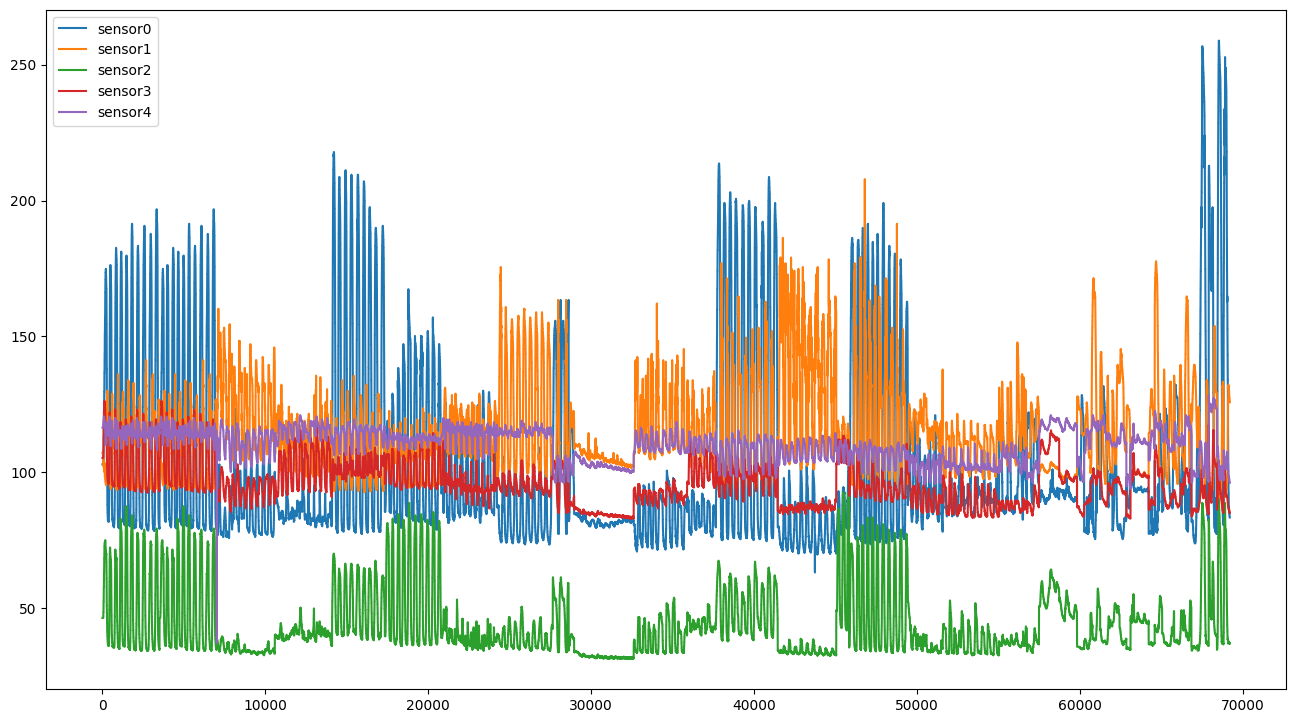

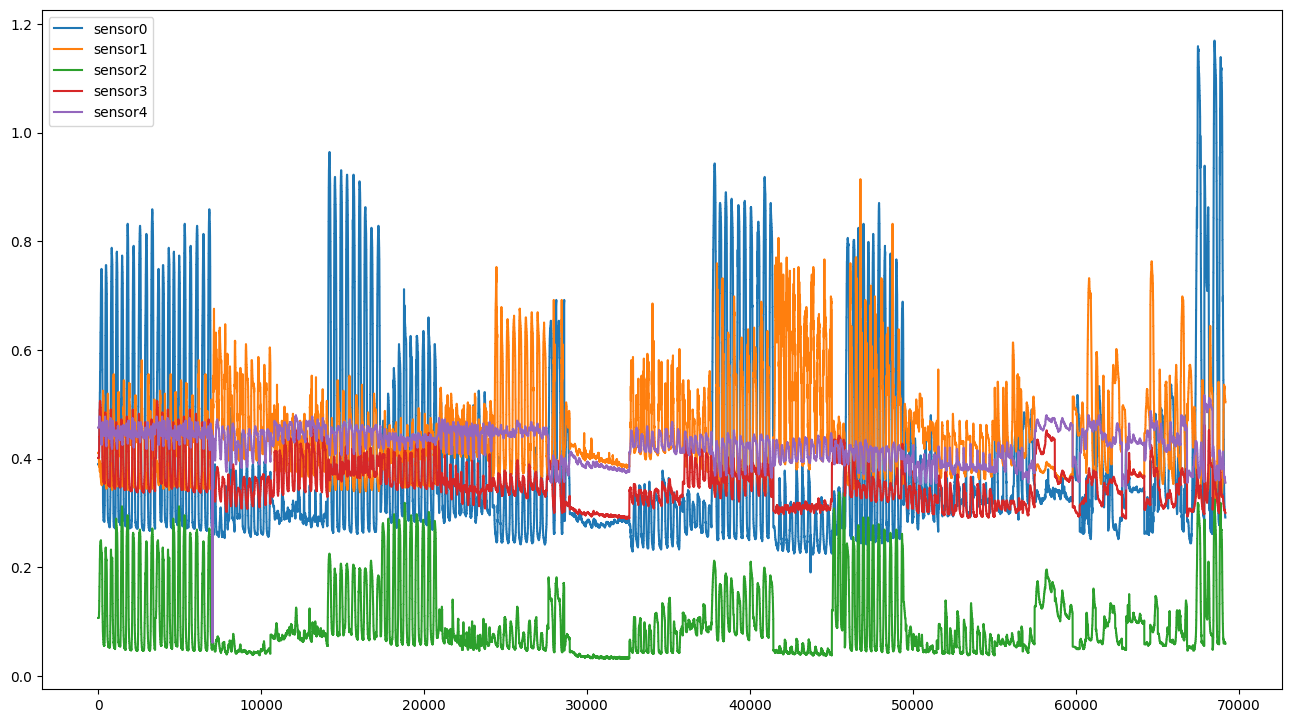

In [10]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def compare_standarize_methods(dataDir='./data/trainset/'):
    sensorPath = Path(dataDir) / "sensor.npy"
    with open(sensorPath, 'rb') as f:
        sensorAll = np.load(f)
    figure(figsize=(16, 9), dpi=100)
    for i in range(5):
        plt.plot(sensorAll[:,i], label=f'sensor{i}')
    plt.legend()
    plt.show()
    
    
    sensorAllStd = np.array(list(map(minmax_scaler, sensorAll)))
    figure(figsize=(16, 9), dpi=100)
    for i in range(5):
        plt.plot(sensorAllStd[:,i], label=f'sensor{i}')
    plt.legend()
    plt.show()
    
compare_standarize_methods()

## Dataloader
- Split dataset into training dataset(90%) and validation dataset(10%).
- Create dataloader to iterate the data.

In [11]:
import torch
from torch.utils.data import DataLoader, random_split

def collate_batch(batch):
    # Process features within a batch.
    """Collate a batch of data."""
    sensor, angle = zip(*batch)
    return torch.FloatTensor(sensor), torch.FloatTensor(angle)


def get_dataloader(data_dir, windowLength, batch_size, n_workers):
    """Generate dataloader"""
    dataset = Sensor2AngleDataset(data_dir, windowLength)
    # Split dataset into training dataset and validation dataset
    trainlen = int(0.9 * len(dataset))
    lengths = [trainlen, len(dataset) - trainlen]
    trainset, validset = random_split(dataset, lengths)
    
    train_loader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=collate_batch,
    )
    valid_loader = DataLoader(
    validset,
    batch_size=batch_size,
    num_workers=n_workers,
    drop_last=True,
    pin_memory=False,
    collate_fn=collate_batch,
    )
    return train_loader, valid_loader

In [12]:
train_loader, valid_loader = get_dataloader('./data/trainset/', 32, 64, 0)
for index, data in enumerate(train_loader):
    print(data[0].size())
    break

(69193, 5)
torch.Size([64, 32, 5])


# Model
- LSTM
- Attention
- ChannleWise-TemporalWise-Attention
- Attention + LSTM
- LSTM + Attention

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CTAttention(nn.Module):
    def __init__(self, d_channel, d_temporal, window_length, dropout):
        super().__init__()
        # Project the dimension of features from that of input into d_model.
        self.channelEncoder = nn.Linear(5, d_channel)
        self.temporalEncoder = nn.Linear(window_length, d_temporal)
        # TODO:
        #   Change Transformer to Conformer.
        #   https://arxiv.org/abs/2005.08100
        self.channelwiseAttentionLayer = nn.TransformerEncoderLayer(
          d_model=window_length, dim_feedforward=1024, nhead=8, dropout=dropout
        )
        self.temporalwiseAttentionLayer = nn.TransformerEncoderLayer(
          d_model=d_temporal, dim_feedforward=1024, nhead=8, dropout=dropout
        )
        self.predLayer = nn.Sequential(
          nn.Linear(d_temporal, d_temporal),
          nn.ReLU(),
          nn.Linear(d_temporal, 6),
        )

    def forward(self, sensors):
        """
        args:
          sensors: (batch size, length, 5)
        return:
          out: (batch size, angles)
        """
        # input: (batch size, length, 5)
        # out: (batch size, length, d_channel)
        out = self.channelEncoder(sensors)
        # The encoder layer expect features in the shape of (args, batch size, args).
        # out: (d_channel, batch size, length)
        out = out.permute(2, 0, 1)
        # out: (d_channel, batch size, length)
        out = self.channelwiseAttentionLayer(out)
        # out: (batch size, d_channel, length)
        out = out.permute(1, 0, 2)
        # out: (batch size, d_channel, d_temporal)
        out = self.temporalEncoder(out)
        # out: (batch size, d_channel, d_temporal)
        out = self.temporalwiseAttentionLayer(out)
        # mean pooling
        stats = out.mean(dim=1)
        # out: (batch, n_output)
        out = self.predLayer(stats)
        return out


from torchinfo import summary
print(summary(CTAttention(d_channel=128, d_temporal=32, window_length=32, dropout=0.1), input_size=(8, 32, 5)))

Layer (type:depth-idx)                   Output Shape              Param #
CTAttention                              --                        --
├─Linear: 1-1                            [8, 32, 128]              768
├─TransformerEncoderLayer: 1-2           [128, 8, 32]              --
│    └─MultiheadAttention: 2-1           [128, 8, 32]              --
│    └─Dropout: 2-2                      [128, 8, 32]              --
│    └─LayerNorm: 2-3                    [128, 8, 32]              64
│    └─Linear: 2-4                       [128, 8, 1024]            33,792
│    └─Dropout: 2-5                      [128, 8, 1024]            --
│    └─Linear: 2-6                       [128, 8, 32]              32,800
│    └─Dropout: 2-7                      [128, 8, 32]              --
│    └─LayerNorm: 2-8                    [128, 8, 32]              64
├─Linear: 1-3                            [8, 128, 32]              1,056
├─TransformerEncoderLayer: 1-4           [8, 128, 32]              --
│  

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionLSTM(nn.Module):
    def __init__(self, 
                 d_channel, 
                 d_temporal, 
                 d_lstm_hidden, 
                 lstm_num_layers,
                 window_length, 
                 dropout):
        super().__init__()
        self.channelEncoder = nn.Linear(5, d_channel)
        self.channelwiseAttentionLayer = nn.TransformerEncoderLayer(
          d_model=window_length, dim_feedforward=512, nhead=8, dropout=dropout)
        self.lstm = nn.LSTM(input_size=d_channel, 
                            hidden_size=d_lstm_hidden,
                            num_layers=lstm_num_layers)
        self.predLayer = nn.Sequential(
          nn.Linear(d_lstm_hidden, d_lstm_hidden),
          nn.ReLU(),
          nn.Linear(d_lstm_hidden, 6))

    def forward(self, sensors):
        """
        About Pytorch LSTM:
        https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM
        args:
          sensors: (batch size, length, 5)
        return:
          out: (batch size, angles)
        """
        # input: (batch size, length, 5)
        out = self.channelEncoder(sensors)          # (batch size, length, d_channel)
        out = out.permute(2, 0, 1)                  # (d_channel, batch size, length)
        out = self.channelwiseAttentionLayer(out)   # (d_channel, batch size, length)
        out = out.permute(2, 1, 0)                  # (length， batch size, d_channel)
        out, (hn, cn) = self.lstm(out)              # (length, batch size, d_lstm_hidden)
        out = out[-1,:,:]                           # (batch size, d_lstm_hidden)    
        out = self.predLayer(out)                   # (batch size, num_angles)
        
        return out


from torchinfo import summary
print(summary(AttentionLSTM(
                 d_channel=128, 
                 d_temporal=32, 
                 d_lstm_hidden=64, 
                 lstm_num_layers=2,
                 window_length=32, 
                 dropout=0.1), 
                 input_size=(8, 32, 5)))

Layer (type:depth-idx)                   Output Shape              Param #
AttentionLSTM                            --                        --
├─Linear: 1-1                            [8, 32, 128]              768
├─TransformerEncoderLayer: 1-2           [128, 8, 32]              --
│    └─MultiheadAttention: 2-1           [128, 8, 32]              --
│    └─Dropout: 2-2                      [128, 8, 32]              --
│    └─LayerNorm: 2-3                    [128, 8, 32]              64
│    └─Linear: 2-4                       [128, 8, 512]             16,896
│    └─Dropout: 2-5                      [128, 8, 512]             --
│    └─Linear: 2-6                       [128, 8, 32]              16,416
│    └─Dropout: 2-7                      [128, 8, 32]              --
│    └─LayerNorm: 2-8                    [128, 8, 32]              64
├─LSTM: 1-3                              [32, 8, 64]               82,944
├─Sequential: 1-4                        [8, 6]                    --
│ 

# Learning rate schedule
- For transformer architecture, the design of learning rate schedule is different from that of CNN.
- Previous works show that the warmup of learning rate is useful for training models with transformer architectures.
- The warmup schedule
  - Set learning rate to 0 in the beginning.
  - The learning rate increases linearly from 0 to initial learning rate during warmup period.

In [15]:
import math

import torch
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR


def get_cosine_schedule_with_warmup(
  optimizer: Optimizer,
  num_warmup_steps: int,
  num_training_steps: int,
  num_cycles: float = 0.5,
  last_epoch: int = -1,
):
    """
    Create a schedule with a learning rate that decreases following the values of the cosine function between the
    initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
    initial lr set in the optimizer.

    Args:
    optimizer (:class:`~torch.optim.Optimizer`):
      The optimizer for which to schedule twhe learning rate.
    num_warmup_steps (:obj:`int`):
      The number of steps for the warmup phase.
    num_training_steps (:obj:`int`):
      The total number of training steps.
    num_cycles (:obj:`float`, `optional`, defaults to 0.5):
      The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
      following a half-cosine).
    last_epoch (:obj:`int`, `optional`, defaults to -1):
      The index of the last epoch when resuming training.

    Return:
    :obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    """

    def lr_lambda(current_step):
        # Warmup
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        # decadence
        progress = float(current_step - num_warmup_steps) / float(
          max(1, num_training_steps - num_warmup_steps)
        )
        return max(
          0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))
        )

    return LambdaLR(optimizer, lr_lambda, last_epoch)

# Model Function
- Model forward function.

In [16]:
import torch


def model_fn(batch, model, criterion, device):
    """Forward a batch through the model."""
    mels, labels = batch
    mels = mels.to(device)
    labels = labels.to(device)
    outs = model(mels)
    loss = criterion(outs, labels)
    
    return loss

In [17]:
# train_loader, valid_loader = get_dataloader(data_dir='./data',
#                                             windowLength=120, 
#                                             batch_size=32, 
#                                             n_workers=0)
# train_iterator = iter(train_loader)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = Attention().to(device)
# batch = next(train_iterator)
# mels, labels = batch
# mels = mels.to(device)
# labels = labels.to(device)

# outs = model(mels)

# Validate
- Calculate mse_loss of the validation set.

In [18]:
from tqdm import tqdm
import torch


def valid(dataloader, model, criterion, device): 
    """Validate on validation set."""
    model.eval()
    running_loss = 0.0
    pbar = tqdm(total=len(dataloader.dataset), ncols=0, desc="Valid", unit=" uttr")

    for i, batch in enumerate(dataloader):
        with torch.no_grad():
            loss = model_fn(batch, model, criterion, device)
            running_loss += loss.item()


        pbar.update(dataloader.batch_size)
        pbar.set_postfix(
        loss=f"{running_loss / (i+1):.2f}")

    pbar.close()
    model.train()

    return running_loss / len(dataloader)

# Train

In [19]:
# from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, random_split

# Attention(d_channel=128, d_temporal=32, window_length=32, dropout=0.1), input_size=(64, 32, 5))

def parse_args():
    """arguments"""
    config = {
    "data_dir": "./data/trainset/",
    "save_path": f"model/CTAttention-{datetime.now().strftime('%Y-%m-%d-%H-%M')}.ckpt",
        
    "window_length": 32,
    "d_channel": 128, 
    "d_temporal": 32,
    "d_lstm_hidden": 128,
    "lstm_num_layers": 2,
    "dropout": 0.1,
    "batch_size": 32,
    
    "n_workers": 0,
    "valid_steps": 2000,
    "warmup_steps": 1000,
    "save_steps": 10000,
    "total_steps": 200000,
    }

    return config


def main(
    data_dir,
    save_path,
    
    window_length,
    d_channel,
    d_temporal,
    d_lstm_hidden,
    lstm_num_layers,
    dropout,
    batch_size,
    
    n_workers,
    valid_steps,
    warmup_steps,
    save_steps,
    total_steps,
):
    """Main function."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[Info]: Use {device} now!")

    train_loader, valid_loader = get_dataloader(data_dir, window_length, batch_size, n_workers)
    train_iterator = iter(train_loader)
    print(f"[Info]: Finish loading data!",flush = True)

    model = CTAttention(d_channel, d_temporal, window_length, dropout=0.1).to(device)
#     model = AttentionLSTM(d_channel,
#                           d_temporal,
#                           d_lstm_hidden,
#                           lstm_num_layers,
#                           window_length,
#                           dropout).to(device)
    criterion = nn.MSELoss()
    optimizer = AdamW(model.parameters(), lr=1e-3)
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    print(f"[Info]: Finish creating model!",flush = True)

    best_mse_loss = 10000.0
    best_state_dict = None

    pbar = tqdm(total=valid_steps, ncols=0, desc="Train", unit=" step")

    for step in range(total_steps):
        # Get data
        try:
            batch = next(train_iterator)
        except StopIteration:
            train_iterator = iter(train_loader)
            batch = next(train_iterator)

        loss = model_fn(batch, model, criterion, device)
        batch_loss = loss.item()

        # Updata model
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Log
        pbar.update()
        pbar.set_postfix(
          loss=f"{batch_loss:.2f}",
          step=step + 1,
        )

        # Do validation
        if (step + 1) % valid_steps == 0:
            pbar.close()
            valid_mse_loss = valid(valid_loader, model, criterion, device)
            # keep the best model
            if valid_mse_loss < best_mse_loss:
                best_mse_loss = valid_mse_loss
                best_state_dict = model.state_dict()
            pbar = tqdm(total=valid_steps, ncols=0, desc="Train", unit=" step")

        # Save the best model so far.
        if (step + 1) % save_steps == 0 and best_state_dict is not None:
            torch.save(best_state_dict, save_path)
            pbar.write(f"Step {step + 1}, best model saved. (mse_loss={best_mse_loss:.4f})")

    pbar.close()


if __name__ == "__main__":
    main(**parse_args())

[Info]: Use cuda now!
(69193, 5)
[Info]: Finish loading data!
[Info]: Finish creating model!


Train: 100% 2000/2000 [00:26<00:00, 74.74 step/s, loss=182.02, step=2000]
Valid: 100% 6912/6917 [00:01<00:00, 5538.44 uttr/s, loss=163.89]
Train: 100% 2000/2000 [00:27<00:00, 73.25 step/s, loss=193.83, step=4000]
Valid: 100% 6912/6917 [00:01<00:00, 5464.04 uttr/s, loss=145.93]
Train: 100% 2000/2000 [00:27<00:00, 72.03 step/s, loss=113.54, step=6000]
Valid: 100% 6912/6917 [00:01<00:00, 5292.52 uttr/s, loss=136.50]
Train: 100% 2000/2000 [00:33<00:00, 59.18 step/s, loss=98.41, step=8000] 
Valid: 100% 6912/6917 [00:01<00:00, 5139.06 uttr/s, loss=116.36]
Train: 100% 2000/2000 [00:33<00:00, 60.10 step/s, loss=70.18, step=1e+4] 
Valid: 100% 6912/6917 [00:01<00:00, 5379.01 uttr/s, loss=100.27]
Train:   1% 12/2000 [00:00<00:30, 65.42 step/s, loss=76.85, step=1e+4] 

Step 10000, best model saved. (mse_loss=100.2685)


Train: 100% 2000/2000 [00:33<00:00, 59.74 step/s, loss=78.22, step=12000] 
Valid: 100% 6912/6917 [00:01<00:00, 5498.82 uttr/s, loss=89.13]
Train: 100% 2000/2000 [00:33<00:00, 60.32 step/s, loss=71.26, step=14000] 
Valid: 100% 6912/6917 [00:01<00:00, 5260.28 uttr/s, loss=87.54]
Train: 100% 2000/2000 [00:33<00:00, 60.58 step/s, loss=83.59, step=16000] 
Valid: 100% 6912/6917 [00:01<00:00, 5296.58 uttr/s, loss=76.85]
Train: 100% 2000/2000 [00:32<00:00, 61.49 step/s, loss=85.89, step=18000] 
Valid: 100% 6912/6917 [00:01<00:00, 5067.47 uttr/s, loss=78.99]
Train: 100% 2000/2000 [00:32<00:00, 61.31 step/s, loss=64.96, step=2e+4]  
Valid: 100% 6912/6917 [00:01<00:00, 5023.27 uttr/s, loss=64.06]
Train:   1% 11/2000 [00:00<00:40, 49.02 step/s, loss=57.57, step=2e+4]

Step 20000, best model saved. (mse_loss=64.0607)


Train: 100% 2000/2000 [00:32<00:00, 61.63 step/s, loss=79.43, step=22000] 
Valid: 100% 6912/6917 [00:01<00:00, 5280.40 uttr/s, loss=65.48]
Train: 100% 2000/2000 [00:31<00:00, 63.65 step/s, loss=91.10, step=24000] 
Valid: 100% 6912/6917 [00:01<00:00, 4864.18 uttr/s, loss=58.73]
Train: 100% 2000/2000 [00:31<00:00, 62.75 step/s, loss=54.54, step=26000] 
Valid: 100% 6912/6917 [00:01<00:00, 5125.44 uttr/s, loss=54.06]
Train: 100% 2000/2000 [00:31<00:00, 62.98 step/s, loss=65.59, step=28000] 
Valid: 100% 6912/6917 [00:01<00:00, 5015.99 uttr/s, loss=50.97]
Train: 100% 2000/2000 [00:31<00:00, 62.77 step/s, loss=28.71, step=3e+4]  
Valid: 100% 6912/6917 [00:01<00:00, 4826.82 uttr/s, loss=50.53]
Train:   1% 12/2000 [00:00<00:35, 55.56 step/s, loss=39.29, step=3e+4]

Step 30000, best model saved. (mse_loss=50.5257)


Train: 100% 2000/2000 [00:31<00:00, 63.17 step/s, loss=38.11, step=32000]
Valid: 100% 6912/6917 [00:01<00:00, 4961.98 uttr/s, loss=52.95]
Train: 100% 2000/2000 [00:32<00:00, 62.22 step/s, loss=30.04, step=34000]
Valid: 100% 6912/6917 [00:01<00:00, 5008.68 uttr/s, loss=49.90]
Train: 100% 2000/2000 [00:32<00:00, 62.07 step/s, loss=27.12, step=36000]
Valid: 100% 6912/6917 [00:01<00:00, 5060.06 uttr/s, loss=47.61]
Train: 100% 2000/2000 [00:33<00:00, 60.26 step/s, loss=41.69, step=38000]
Valid: 100% 6912/6917 [00:01<00:00, 4657.67 uttr/s, loss=44.27]
Train: 100% 2000/2000 [00:32<00:00, 60.94 step/s, loss=23.99, step=4e+4] 
Valid: 100% 6912/6917 [00:01<00:00, 4983.42 uttr/s, loss=53.92]
Train:   0% 9/2000 [00:00<00:37, 52.63 step/s, loss=13.06, step=4e+4]

Step 40000, best model saved. (mse_loss=44.2688)


Train: 100% 2000/2000 [00:33<00:00, 60.05 step/s, loss=19.56, step=42000]
Valid: 100% 6912/6917 [00:01<00:00, 4997.88 uttr/s, loss=37.56]
Train: 100% 2000/2000 [00:33<00:00, 60.19 step/s, loss=57.84, step=44000]
Valid: 100% 6912/6917 [00:01<00:00, 4919.59 uttr/s, loss=38.05]
Train: 100% 2000/2000 [00:31<00:00, 62.52 step/s, loss=20.06, step=46000]
Valid: 100% 6912/6917 [00:01<00:00, 4926.62 uttr/s, loss=46.31]
Train: 100% 2000/2000 [00:32<00:00, 61.76 step/s, loss=16.32, step=48000]
Valid: 100% 6912/6917 [00:01<00:00, 5082.39 uttr/s, loss=37.18]
Train: 100% 2000/2000 [00:32<00:00, 60.72 step/s, loss=15.06, step=5e+4] 
Valid: 100% 6912/6917 [00:01<00:00, 4898.65 uttr/s, loss=32.77]
Train:   1% 11/2000 [00:00<00:34, 57.69 step/s, loss=17.95, step=5e+4]

Step 50000, best model saved. (mse_loss=32.7721)


Train: 100% 2000/2000 [00:33<00:00, 60.25 step/s, loss=27.36, step=52000]
Valid: 100% 6912/6917 [00:01<00:00, 5089.83 uttr/s, loss=36.39]
Train: 100% 2000/2000 [00:32<00:00, 60.92 step/s, loss=9.65, step=54000] 
Valid: 100% 6912/6917 [00:01<00:00, 5139.06 uttr/s, loss=27.47]
Train: 100% 2000/2000 [00:32<00:00, 62.40 step/s, loss=15.34, step=56000]
Valid: 100% 6912/6917 [00:01<00:00, 4651.43 uttr/s, loss=30.26]
Train: 100% 2000/2000 [00:32<00:00, 60.94 step/s, loss=33.03, step=58000]
Valid: 100% 6912/6917 [00:01<00:00, 5082.39 uttr/s, loss=32.87]
Train: 100% 2000/2000 [00:32<00:00, 61.63 step/s, loss=17.63, step=6e+4] 
Valid: 100% 6912/6917 [00:01<00:00, 5236.38 uttr/s, loss=35.24]
Train:   0% 9/2000 [00:00<00:42, 47.17 step/s, loss=19.22, step=6e+4]

Step 60000, best model saved. (mse_loss=27.4729)


Train: 100% 2000/2000 [00:32<00:00, 61.32 step/s, loss=16.29, step=62000]
Valid: 100% 6912/6917 [00:01<00:00, 5019.57 uttr/s, loss=32.28]
Train: 100% 2000/2000 [00:33<00:00, 59.98 step/s, loss=29.85, step=64000]
Valid: 100% 6912/6917 [00:01<00:00, 4860.77 uttr/s, loss=30.02]
Train: 100% 2000/2000 [00:32<00:00, 61.48 step/s, loss=12.26, step=66000]
Valid: 100% 6912/6917 [00:01<00:00, 5312.83 uttr/s, loss=31.26]
Train: 100% 2000/2000 [00:31<00:00, 62.52 step/s, loss=12.66, step=68000]
Valid: 100% 6912/6917 [00:01<00:00, 4888.25 uttr/s, loss=33.89]
Train: 100% 2000/2000 [00:32<00:00, 60.76 step/s, loss=29.16, step=7e+4] 
Valid: 100% 6912/6917 [00:01<00:00, 4853.94 uttr/s, loss=24.93]
Train:   1% 13/2000 [00:00<00:31, 62.50 step/s, loss=20.14, step=7e+4]

Step 70000, best model saved. (mse_loss=24.9337)


Train: 100% 2000/2000 [00:31<00:00, 62.92 step/s, loss=35.45, step=72000]
Valid: 100% 6912/6917 [00:01<00:00, 5490.08 uttr/s, loss=33.44]
Train: 100% 2000/2000 [00:32<00:00, 61.48 step/s, loss=8.08, step=74000] 
Valid: 100% 6912/6917 [00:01<00:00, 5391.60 uttr/s, loss=27.18]
Train: 100% 2000/2000 [00:32<00:00, 61.54 step/s, loss=11.15, step=76000]
Valid: 100% 6912/6917 [00:01<00:00, 5248.30 uttr/s, loss=26.38]
Train: 100% 2000/2000 [00:32<00:00, 62.01 step/s, loss=13.33, step=78000] 
Valid: 100% 6912/6917 [00:01<00:00, 5165.92 uttr/s, loss=27.76]
Train: 100% 2000/2000 [00:33<00:00, 59.98 step/s, loss=8.99, step=8e+4]  
Valid: 100% 6912/6917 [00:01<00:00, 5071.19 uttr/s, loss=23.91]
Train:   1% 11/2000 [00:00<00:35, 55.56 step/s, loss=9.74, step=8e+4] 

Step 80000, best model saved. (mse_loss=23.9082)


Train: 100% 2000/2000 [00:32<00:00, 61.31 step/s, loss=12.80, step=82000]
Valid: 100% 6912/6917 [00:01<00:00, 5181.42 uttr/s, loss=21.84]
Train: 100% 2000/2000 [00:32<00:00, 62.07 step/s, loss=11.83, step=84000]
Valid: 100% 6912/6917 [00:01<00:00, 5131.40 uttr/s, loss=29.21]
Train: 100% 2000/2000 [00:32<00:00, 61.04 step/s, loss=9.51, step=86000] 
Valid: 100% 6912/6917 [00:01<00:00, 5288.47 uttr/s, loss=22.52]
Train: 100% 2000/2000 [00:32<00:00, 61.34 step/s, loss=8.55, step=88000] 
Valid: 100% 6912/6917 [00:01<00:00, 5438.26 uttr/s, loss=22.04]
Train: 100% 2000/2000 [00:31<00:00, 62.61 step/s, loss=6.83, step=9e+4]  
Valid: 100% 6912/6917 [00:01<00:00, 5185.33 uttr/s, loss=30.28]
Train:   1% 13/2000 [00:00<00:30, 64.81 step/s, loss=10.12, step=9e+4]

Step 90000, best model saved. (mse_loss=21.8392)


Train: 100% 2000/2000 [00:29<00:00, 67.12 step/s, loss=9.93, step=92000] 
Valid: 100% 6912/6917 [00:01<00:00, 5624.09 uttr/s, loss=21.20]
Train: 100% 2000/2000 [00:26<00:00, 76.82 step/s, loss=10.44, step=94000]
Valid: 100% 6912/6917 [00:01<00:00, 5181.41 uttr/s, loss=26.83]
Train: 100% 2000/2000 [00:25<00:00, 79.19 step/s, loss=13.54, step=96000]
Valid: 100% 6912/6917 [00:01<00:00, 5516.36 uttr/s, loss=29.32]
Train: 100% 2000/2000 [00:25<00:00, 78.51 step/s, loss=10.00, step=98000]
Valid: 100% 6912/6917 [00:01<00:00, 5341.55 uttr/s, loss=21.11]
Train: 100% 2000/2000 [00:25<00:00, 79.17 step/s, loss=8.25, step=1e+5]  
Valid: 100% 6912/6917 [00:01<00:00, 5494.42 uttr/s, loss=21.05]
Train:   1% 15/2000 [00:00<00:27, 72.07 step/s, loss=18.80, step=1e+5]

Step 100000, best model saved. (mse_loss=21.0497)


Train: 100% 2000/2000 [00:25<00:00, 78.52 step/s, loss=12.40, step=102000]
Valid: 100% 6912/6917 [00:01<00:00, 5425.43 uttr/s, loss=21.57]
Train: 100% 2000/2000 [00:25<00:00, 78.58 step/s, loss=11.63, step=104000]
Valid: 100% 6912/6917 [00:01<00:00, 5391.58 uttr/s, loss=24.14]
Train: 100% 2000/2000 [00:25<00:00, 78.69 step/s, loss=4.41, step=106000] 
Valid: 100% 6912/6917 [00:01<00:00, 5383.17 uttr/s, loss=23.20]
Train: 100% 2000/2000 [00:25<00:00, 79.21 step/s, loss=8.70, step=108000] 
Valid: 100% 6912/6917 [00:01<00:00, 5349.84 uttr/s, loss=20.18]
Train: 100% 2000/2000 [00:25<00:00, 78.63 step/s, loss=4.80, step=110000] 
Valid: 100% 6912/6917 [00:01<00:00, 5391.58 uttr/s, loss=22.50]
Train:   1% 15/2000 [00:00<00:26, 74.07 step/s, loss=11.88, step=110015]

Step 110000, best model saved. (mse_loss=20.1833)


Train: 100% 2000/2000 [00:25<00:00, 77.74 step/s, loss=6.97, step=112000] 
Valid: 100% 6912/6917 [00:01<00:00, 5268.30 uttr/s, loss=19.03]
Train: 100% 2000/2000 [00:25<00:00, 77.46 step/s, loss=3.70, step=114000] 
Valid: 100% 6912/6917 [00:01<00:00, 5304.68 uttr/s, loss=22.18]
Train: 100% 2000/2000 [00:25<00:00, 77.66 step/s, loss=9.63, step=116000] 
Valid: 100% 6912/6917 [00:01<00:00, 5196.98 uttr/s, loss=22.54]
Train: 100% 2000/2000 [00:25<00:00, 77.23 step/s, loss=9.53, step=118000] 
Valid: 100% 6912/6917 [00:01<00:00, 5185.29 uttr/s, loss=22.88]
Train: 100% 2000/2000 [00:25<00:00, 77.50 step/s, loss=7.31, step=120000] 
Valid: 100% 6912/6917 [00:01<00:00, 5316.92 uttr/s, loss=19.66]
Train:   1% 13/2000 [00:00<00:30, 65.42 step/s, loss=6.16, step=120013] 

Step 120000, best model saved. (mse_loss=19.0250)


Train: 100% 2000/2000 [00:25<00:00, 77.58 step/s, loss=6.87, step=122000] 
Valid: 100% 6912/6917 [00:01<00:00, 5252.30 uttr/s, loss=20.70]
Train: 100% 2000/2000 [00:26<00:00, 76.92 step/s, loss=7.09, step=124000] 
Valid: 100% 6912/6917 [00:01<00:00, 5296.56 uttr/s, loss=18.32]
Train: 100% 2000/2000 [00:25<00:00, 77.37 step/s, loss=5.73, step=126000] 
Valid: 100% 6912/6917 [00:01<00:00, 4947.75 uttr/s, loss=20.44]
Train: 100% 2000/2000 [00:25<00:00, 77.06 step/s, loss=4.85, step=128000] 
Valid: 100% 6912/6917 [00:01<00:00, 5252.28 uttr/s, loss=24.66]
Train: 100% 2000/2000 [00:25<00:00, 77.25 step/s, loss=3.33, step=130000] 
Valid: 100% 6912/6917 [00:01<00:00, 5150.51 uttr/s, loss=22.28]
Train:   1% 14/2000 [00:00<00:29, 67.96 step/s, loss=3.62, step=130014]

Step 130000, best model saved. (mse_loss=18.3177)


Train: 100% 2000/2000 [00:26<00:00, 76.79 step/s, loss=5.95, step=132000] 
Valid: 100% 6912/6917 [00:01<00:00, 5067.46 uttr/s, loss=20.09]
Train: 100% 2000/2000 [00:26<00:00, 76.66 step/s, loss=4.64, step=134000] 
Valid: 100% 6912/6917 [00:01<00:00, 5325.12 uttr/s, loss=20.61]
Train: 100% 2000/2000 [00:25<00:00, 77.19 step/s, loss=3.99, step=136000] 
Valid: 100% 6912/6917 [00:01<00:00, 5244.32 uttr/s, loss=20.83]
Train: 100% 2000/2000 [00:26<00:00, 76.56 step/s, loss=5.89, step=138000] 
Valid: 100% 6912/6917 [00:01<00:00, 5158.21 uttr/s, loss=18.72]
Train: 100% 2000/2000 [00:25<00:00, 77.22 step/s, loss=6.16, step=140000] 
Valid: 100% 6912/6917 [00:01<00:00, 5341.58 uttr/s, loss=19.37]
Train:   1% 14/2000 [00:00<00:26, 74.77 step/s, loss=3.97, step=140014]

Step 140000, best model saved. (mse_loss=18.3177)


Train: 100% 2000/2000 [00:26<00:00, 76.22 step/s, loss=2.17, step=142000] 
Valid: 100% 6912/6917 [00:01<00:00, 5193.09 uttr/s, loss=18.83]
Train: 100% 2000/2000 [00:25<00:00, 77.37 step/s, loss=3.84, step=144000] 
Valid: 100% 6912/6917 [00:01<00:00, 5284.41 uttr/s, loss=19.47]
Train: 100% 2000/2000 [00:26<00:00, 76.32 step/s, loss=3.40, step=146000] 
Valid: 100% 6912/6917 [00:01<00:00, 5312.84 uttr/s, loss=21.43]
Train: 100% 2000/2000 [00:26<00:00, 76.59 step/s, loss=3.37, step=148000] 
Valid: 100% 6912/6917 [00:01<00:00, 5349.84 uttr/s, loss=20.02]
Train: 100% 2000/2000 [00:25<00:00, 77.53 step/s, loss=4.12, step=150000] 
Valid: 100% 6912/6917 [00:01<00:00, 5181.42 uttr/s, loss=18.81]
Train:   1% 14/2000 [00:00<00:28, 69.56 step/s, loss=3.05, step=150014]

Step 150000, best model saved. (mse_loss=18.3177)


Train: 100% 2000/2000 [00:25<00:00, 76.98 step/s, loss=3.19, step=152000]
Valid: 100% 6912/6917 [00:01<00:00, 5264.29 uttr/s, loss=20.21]
Train: 100% 2000/2000 [00:25<00:00, 77.95 step/s, loss=3.38, step=154000] 
Valid: 100% 6912/6917 [00:01<00:00, 5252.27 uttr/s, loss=19.43]
Train: 100% 2000/2000 [00:25<00:00, 77.52 step/s, loss=2.78, step=156000] 
Valid: 100% 6912/6917 [00:01<00:00, 5135.21 uttr/s, loss=19.88]
Train: 100% 2000/2000 [00:25<00:00, 77.20 step/s, loss=4.15, step=158000]
Valid: 100% 6912/6917 [00:01<00:00, 5276.33 uttr/s, loss=20.98]
Train: 100% 2000/2000 [00:25<00:00, 77.29 step/s, loss=3.20, step=160000]
Valid: 100% 6912/6917 [00:01<00:00, 5146.70 uttr/s, loss=18.81]
Train:   1% 15/2000 [00:00<00:26, 75.47 step/s, loss=2.87, step=160015]

Step 160000, best model saved. (mse_loss=18.3177)


Train: 100% 2000/2000 [00:26<00:00, 76.83 step/s, loss=2.58, step=162000] 
Valid: 100% 6912/6917 [00:01<00:00, 5288.44 uttr/s, loss=21.53]
Train: 100% 2000/2000 [00:25<00:00, 77.15 step/s, loss=5.06, step=164000]
Valid: 100% 6912/6917 [00:01<00:00, 5071.16 uttr/s, loss=21.25]
Train: 100% 2000/2000 [00:26<00:00, 76.38 step/s, loss=2.05, step=166000]
Valid: 100% 6912/6917 [00:01<00:00, 5052.63 uttr/s, loss=18.97]
Train: 100% 2000/2000 [00:25<00:00, 77.05 step/s, loss=2.25, step=168000]
Valid: 100% 6912/6917 [00:01<00:00, 5162.07 uttr/s, loss=20.73]
Train: 100% 2000/2000 [00:25<00:00, 77.89 step/s, loss=3.39, step=170000]
Valid: 100% 6912/6917 [00:01<00:00, 5142.86 uttr/s, loss=19.53]
Train:   1% 14/2000 [00:00<00:30, 65.42 step/s, loss=2.45, step=170014]

Step 170000, best model saved. (mse_loss=18.3177)


Train: 100% 2000/2000 [00:26<00:00, 76.91 step/s, loss=3.61, step=172000]
Valid: 100% 6912/6917 [00:01<00:00, 5244.31 uttr/s, loss=20.50]
Train: 100% 2000/2000 [00:25<00:00, 77.52 step/s, loss=2.58, step=174000]
Valid: 100% 6912/6917 [00:01<00:00, 5189.17 uttr/s, loss=19.81]
Train: 100% 2000/2000 [00:25<00:00, 77.07 step/s, loss=2.41, step=176000]
Valid: 100% 6912/6917 [00:01<00:00, 5116.21 uttr/s, loss=19.79]
Train: 100% 2000/2000 [00:25<00:00, 77.03 step/s, loss=2.49, step=178000]
Valid: 100% 6912/6917 [00:01<00:00, 5408.44 uttr/s, loss=19.77]
Train: 100% 2000/2000 [00:26<00:00, 76.42 step/s, loss=4.65, step=180000]
Valid: 100% 6912/6917 [00:01<00:00, 5185.30 uttr/s, loss=20.72]
Train:   1% 14/2000 [00:00<00:27, 72.73 step/s, loss=3.03, step=180014]

Step 180000, best model saved. (mse_loss=18.3177)


Train: 100% 2000/2000 [00:25<00:00, 76.95 step/s, loss=3.84, step=182000]
Valid: 100% 6912/6917 [00:01<00:00, 5256.27 uttr/s, loss=20.46]
Train: 100% 2000/2000 [00:26<00:00, 76.70 step/s, loss=2.20, step=184000]
Valid: 100% 6912/6917 [00:01<00:00, 5300.64 uttr/s, loss=19.69]
Train: 100% 2000/2000 [00:26<00:00, 76.80 step/s, loss=2.71, step=186000]
Valid: 100% 6912/6917 [00:01<00:00, 5236.37 uttr/s, loss=20.24]
Train: 100% 2000/2000 [00:26<00:00, 76.91 step/s, loss=2.86, step=188000]
Valid: 100% 6912/6917 [00:01<00:00, 5208.75 uttr/s, loss=20.24]
Train: 100% 2000/2000 [00:25<00:00, 77.09 step/s, loss=2.22, step=190000]
Valid: 100% 6912/6917 [00:01<00:00, 5169.80 uttr/s, loss=19.86]
Train:   1% 12/2000 [00:00<00:29, 66.67 step/s, loss=4.05, step=190012]

Step 190000, best model saved. (mse_loss=18.3177)


Train: 100% 2000/2000 [00:26<00:00, 76.60 step/s, loss=5.25, step=192000]
Valid: 100% 6912/6917 [00:01<00:00, 5288.46 uttr/s, loss=20.28]
Train: 100% 2000/2000 [00:25<00:00, 78.89 step/s, loss=2.33, step=194000]
Valid: 100% 6912/6917 [00:01<00:00, 5185.30 uttr/s, loss=20.26]
Train: 100% 2000/2000 [00:26<00:00, 76.07 step/s, loss=3.65, step=196000]
Valid: 100% 6912/6917 [00:01<00:00, 5177.52 uttr/s, loss=20.35]
Train: 100% 2000/2000 [00:26<00:00, 76.69 step/s, loss=3.35, step=198000]
Valid: 100% 6912/6917 [00:01<00:00, 5150.51 uttr/s, loss=20.20]
Train: 100% 2000/2000 [00:25<00:00, 77.55 step/s, loss=3.68, step=2e+5]  
Valid: 100% 6912/6917 [00:01<00:00, 5264.28 uttr/s, loss=20.21]
Train:   0% 0/2000 [00:00<?, ? step/s]

Step 200000, best model saved. (mse_loss=18.3177)


# Evaluation

In [24]:
import json
import csv
from pathlib import Path
from tqdm.notebook import tqdm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

def parse_args():
    """arguments"""
    config = {
    "data_dir": "./data/trainset/",
    "model_path": "./model/CTAttention-2021-09-09-21-37.ckpt",
    "output_path": "./result/output.csv",          
    "window_length": 32,
    "d_channel": 128, 
    "d_temporal": 32,
    "d_lstm_hidden": 128,
    "lstm_num_layers": 2,
    "dropout": 0.0,
    "batch_size": 1
    }

    return config


def evaluation(
    data_dir,
    model_path,
    output_path,
    window_length,
    d_channel,
    d_temporal, 
    d_lstm_hidden,
    lstm_num_layers,
    dropout,
    batch_size
):

    """Main function."""
    _, tempfilename = os.path.split(model_path)
    (modelName, extension) = os.path.splitext(tempfilename)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[Info]: Use {device} now!")

    dataset = Sensor2AngleDataset(data_dir, window_length)
    
    dataloader = DataLoader(
    dataset,
    batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=0,
    collate_fn=collate_batch,
    )
    print(f"[Info]: Finish loading data!",flush = True)
    
    model = CTAttention(d_channel, d_temporal, window_length, dropout)
#     model = AttentionLSTM(d_channel,
#                           d_temporal,
#                           d_lstm_hidden,
#                           lstm_num_layers,
#                           window_length,
#                           dropout)
#     model.load_state_dict(torch.load(model_path))
    model.eval()
    print(f"[Info]: Finish creating model!",flush = True)
    
    criterion = nn.MSELoss()
    loss_list = []
    results = [["Label", "Preds"]]
    angles_list = []
    preds_list = []
    for sensor, angle in tqdm(dataloader):
        with torch.no_grad():
#             sensor = sensor.to(device)
            sensor = sensor
            outs = model(sensor)
            preds = outs.cpu()
            results.append([angle.numpy(), preds.numpy()])
            angles_list.append(angle.numpy())
            preds_list.append(preds.numpy())
            
            loss = criterion(preds, angle)
            loss_list.append(loss.item())

    with open(output_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(results)
        print(f"[Info]: Finish save results!",flush = True)
        
    # logging
    logger = get_logger('info', log_file=f'./log/{modelName}.log')
    logger.info(f'RMSE loss:, {np.sqrt(np.array(loss_list).mean())}')

    preds_list = np.array(preds_list).squeeze()
    angles_list = np.array(angles_list).squeeze()
    
    return preds_list, angles_list
    
if __name__ == "__main__":
    preds_list, angle_list = evaluation(**parse_args())

[Info]: Use cuda now!
(69193, 5)
[Info]: Finish loading data!
[Info]: Finish creating model!


  0%|          | 0/69162 [00:00<?, ?it/s]

[Info]: Finish save results!


[2021-09-10 02:36:26,026] [INFO] RMSE loss:, 32.99310800734442


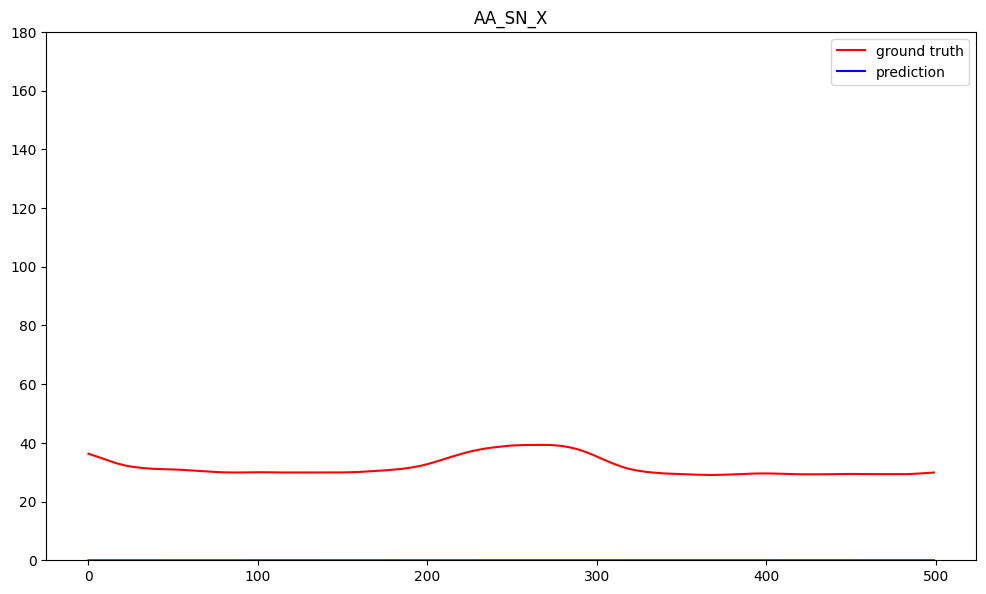

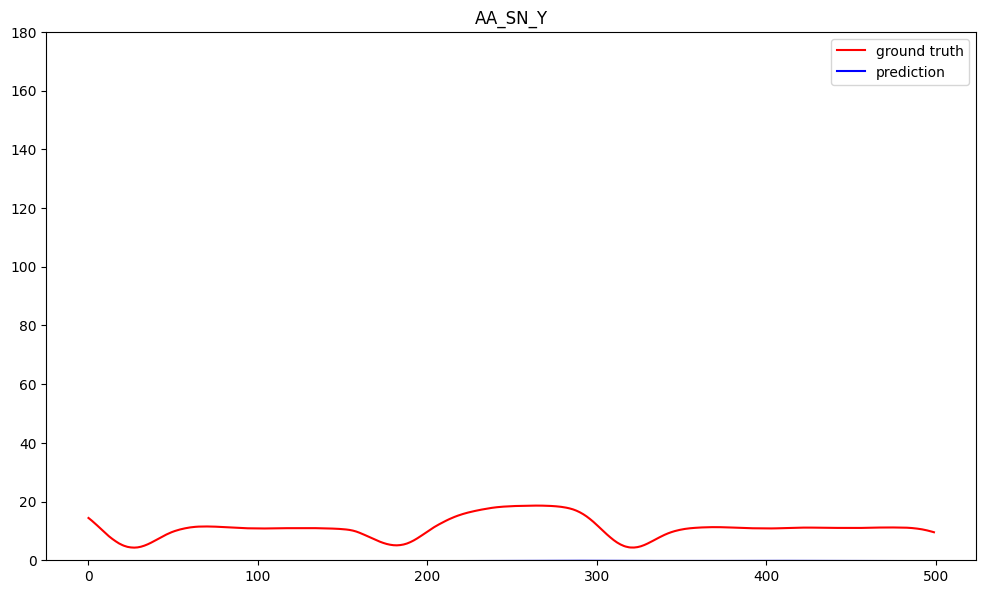

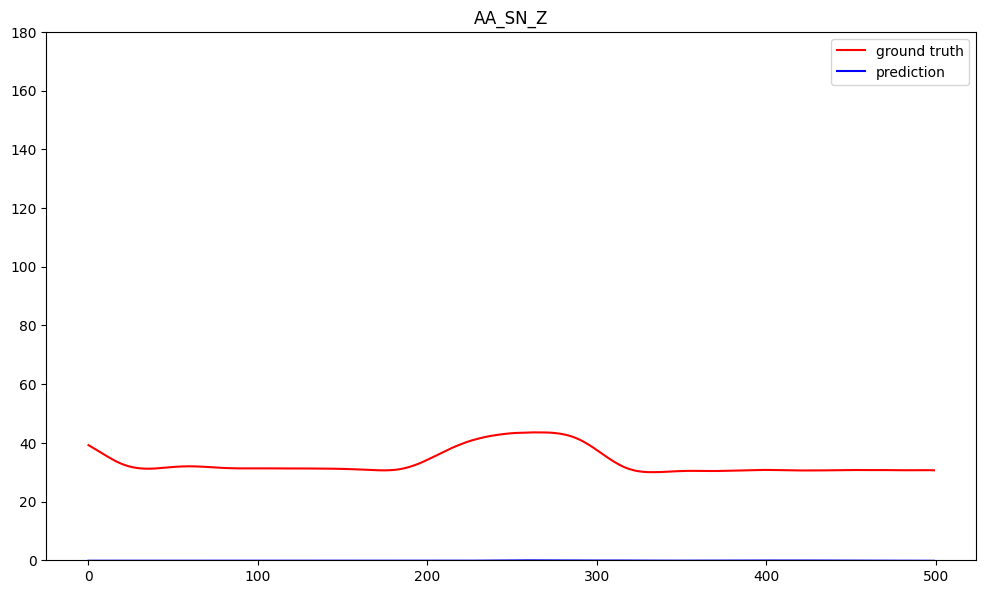

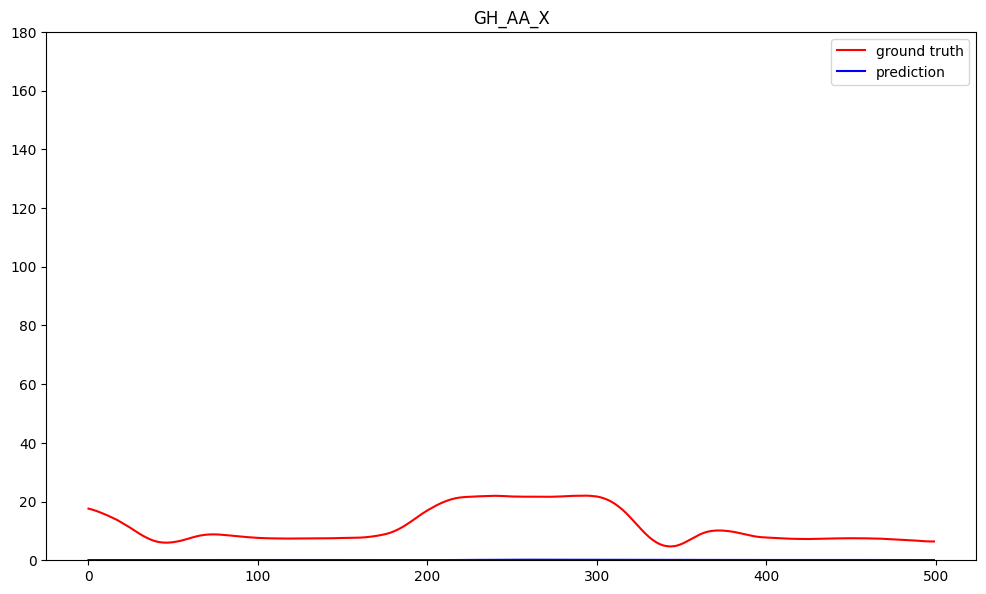

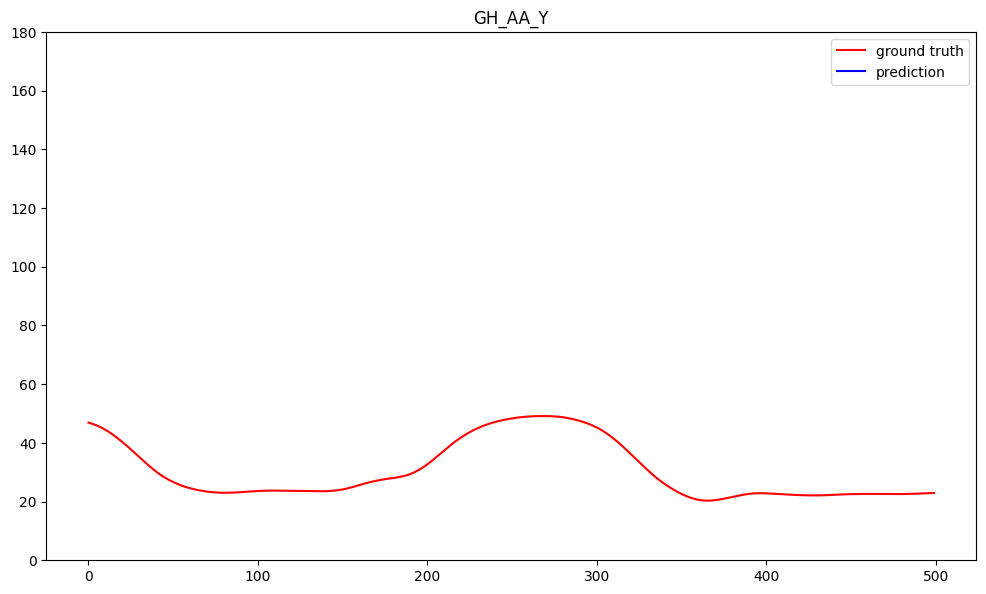

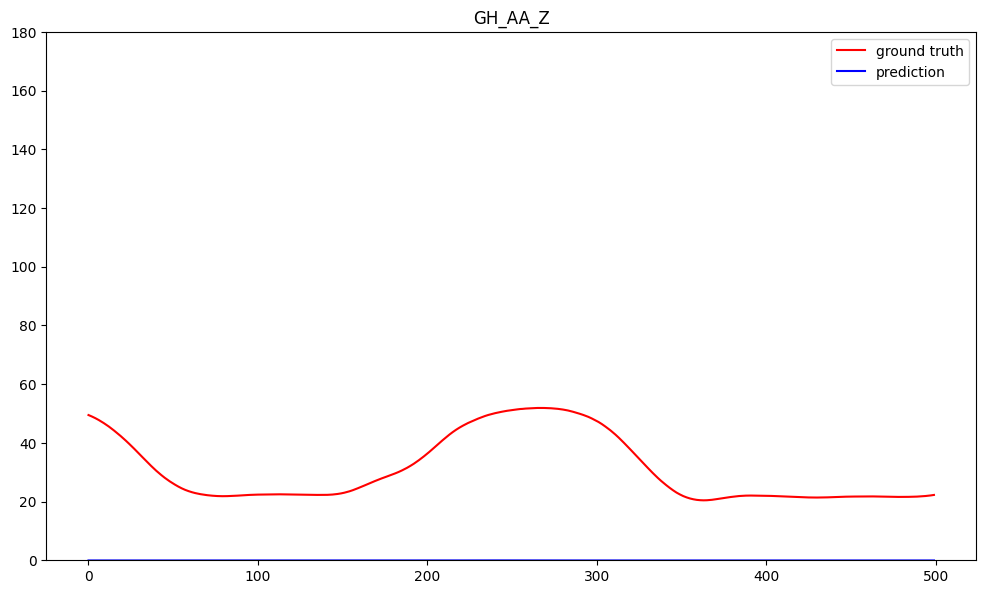

In [30]:
    
def visualize_result(label, predict, modelName):
    for i in range(6):
        figure(figsize=(12, 7), dpi=100)
        plt.plot(label[:500,i], color='r', label='ground truth')
        plt.plot(predict[:500,i], color='b', label='prediction')
        plt.title(label_names[i])
        axes = plt.gca()
        axes.set_ylim([0,180])
        plt.legend()
        plt.savefig(f'result/test/trainDataset_{label_names[i]}_{modelName}.png')
    plt.show()

modelName = 'CTAttention-2021-09-09-21-37'
visualize_result(angle_list[:], preds_list[:], modelName)

# Inference

In [ ]:
import json
import csv
from pathlib import Path
from tqdm.notebook import tqdm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

def parse_args():
    """arguments"""
    config = {
    "data_dir": "./data/testset/slow.npy",
    "model_path": "./model/attentionLSTM-2021-09-09-15-03.ckpt",
    "output_path": "./result/output.csv",
        
    "window_length": 32,
    "d_channel": 128, 
    "d_temporal": 32,
    "d_lstm_hidden": 128,
    "lstm_num_layers": 2,
    "dropout": 0.0,
    "batch_size": 1
    }

    return config


def inference(
    data_dir,
    model_path,
    output_path,
    window_length,
    d_channel, 
    d_temporal,
    d_lstm_hidden,
    lstm_num_layers,
    dropout,
    batch_size
):
    """Main function."""
    _, tempfilename = os.path.split(model_path)
    (modelName, extension) = os.path.splitext(tempfilename)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[Info]: Use {device} now!")

    dataset = Sensor2AngleTestDataset(data_dir, window_length)
    dataloader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    drop_last=False,
    num_workers=0,
    )
    
    print(f"[Info]: Finish loading data!",flush = True)
    
#     model = Attention(d_model, dropout).to(device)
    model = AttentionLSTM(d_channel,
                          d_temporal,
                          d_lstm_hidden,
                          lstm_num_layers,
                          window_length,
                          dropout)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print(f"[Info]: Finish creating model!",flush = True)
    
    preds_list = []
    for sensor in tqdm(dataloader):
        with torch.no_grad():
            sensor = sensor.float()
            outs = model(sensor)
            preds = outs.cpu()
            preds_list.append(preds.numpy())
    # visualization
    preds_list = np.array(preds_list).squeeze()
    sensor_list = np.load(data_dir)
    visualize_result(sensor_list, preds_list, folderPath=logpath, dataDir=data_dir)

    
def visualize_result(sensor, predict, folderPath, dataDir):
    figure(figsize=(12, 7), dpi=100)
    axes = plt.gca()
    axes.set_ylim([0,180])
    for i in range(6):
        plt.plot(predict[:,i], label=label_names[i])
        plt.legend()
    for j in range(5):
        plt.plot(sensor[:,j], color='b', label=label_names[j])
    plt.title(dataDir)
    os.mkdir(os.path.join('./result/fading/', os.path.basename(folderPath)))
    savefigPath = os.path.join(f'./result/fading/',
                                os.path.basename(modelName),
                                os.path.basename(dataDir).replace('.npy', '.png'))
    plt.savefig(savefigPath)
    plt.show()

if __name__ == "__main__":
    inference(**parse_args())